# Sandbox notebook for data analysis and visualization

Author: Veikka Immonen

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from PIL import Image

from tqdm import tqdm

import scienceplots

plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

from sklearn.model_selection import train_test_split

plt_original_resolution = plt.rcParams['figure.figsize']
plt_original_resolution

[3.5, 2.625]

## CytoSense

In [2]:
data_dir = Path('./data/FASTVISION-plus')
image_dir = data_dir / 'images'
profile_dir = data_dir / 'profiles'
annotations = pd.read_csv(data_dir / 'annotations.csv')
annotations, len(annotations)

(          ID               class_name
 0          1  Aphanizomenon_flosaquae
 1          2  Aphanizomenon_flosaquae
 2          3  Aphanizomenon_flosaquae
 3          4  Aphanizomenon_flosaquae
 4          5  Aphanizomenon_flosaquae
 ...      ...                      ...
 20045  20046           Tetraselmis_sp
 20046  20047           Tetraselmis_sp
 20047  20048           Tetraselmis_sp
 20048  20049           Tetraselmis_sp
 20049  20050           Tetraselmis_sp
 
 [20050 rows x 2 columns],
 20050)

### Statistics

Number of samples for each instance, how many of them are purely multimodal 
(images + all time series data)?

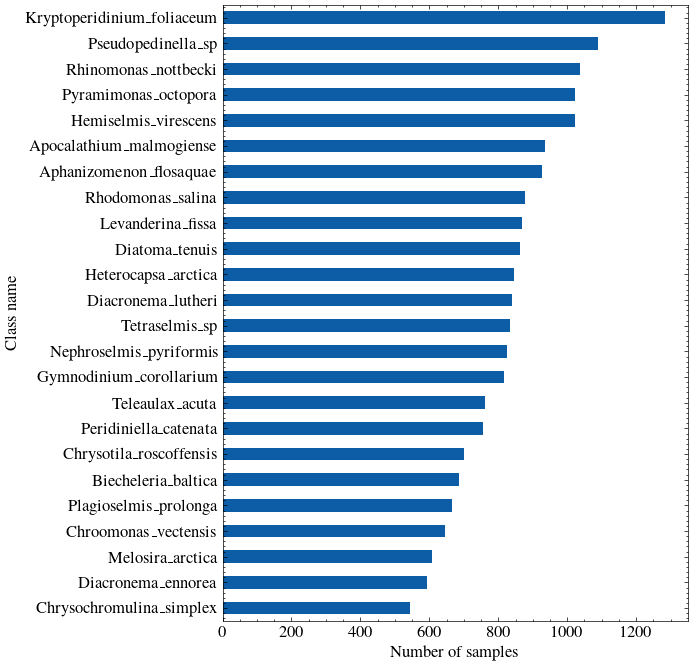

,0
Aphanizomenon_flosaquae,926
Apocalathium_malmogiense,936
Biecheleria_baltica,685
Chroomonas_vectensis,645
Chrysochromulina_simplex,543
Gymnodinium_corollarium,818
Hemiselmis_virescens,1022
Heterocapsa_arctica,846
Levanderina_fissa,870
Melosira_arctica,608


In [4]:
counter = Counter(annotations.class_name)

df = pd.DataFrame(
    data=counter.values(),
    index=counter.keys(),
)

df.sort_values(0).plot(kind='barh', figsize=(6, 8), legend=False)
plt.xlabel('Number of samples')
plt.ylabel('Class name')

plt.savefig(f'figures/sample_counts.pdf')
plt.show()
df

Rough selection would be to exclude classes with less than 10 multimodal samples.

### Visualization

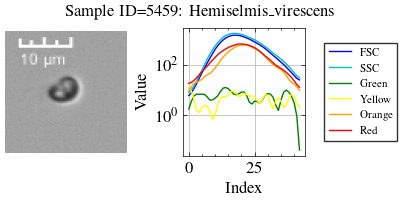

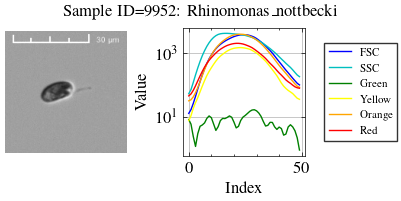

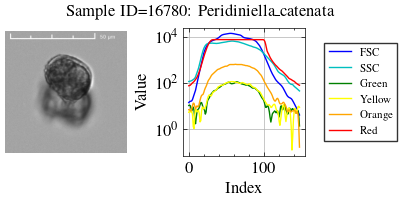

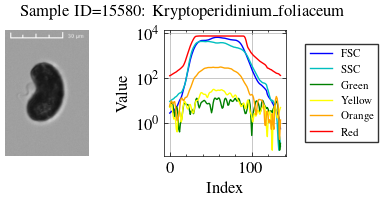

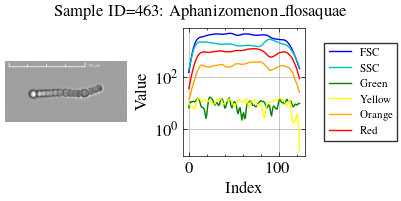

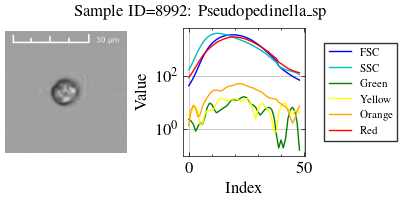

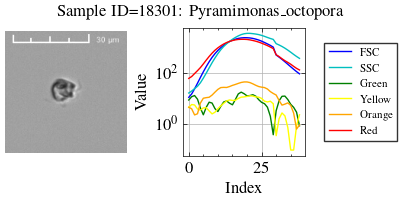

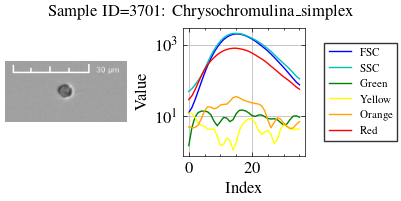

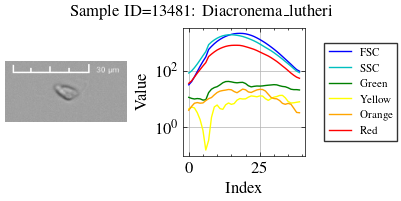

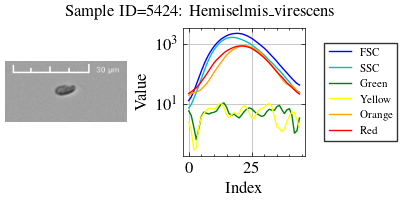

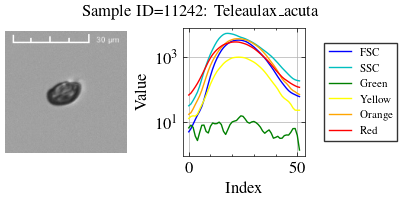

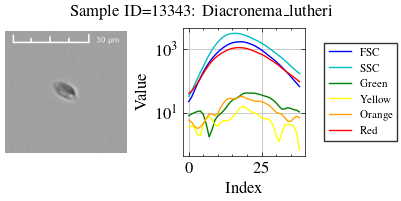

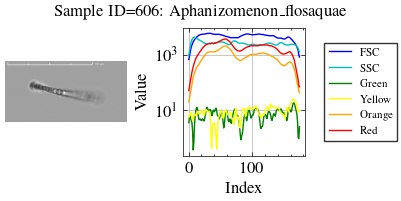

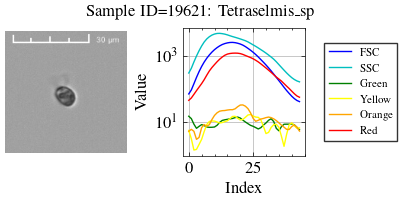

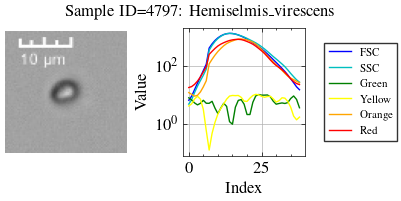

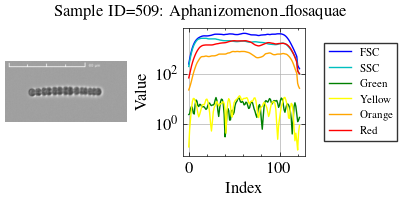

In [26]:
def visualize(sample):
    image = np.array(Image.open(image_dir / f"{sample.ID}.jpg"))
    profile = pd.read_csv(profile_dir / f"{sample.ID}.csv")

    styles = ['b', 'c', 'g', 'yellow', 'orange', 'r', 'k']

    fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")

    ax1.imshow(image)
    ax1.set_axis_off()

    ax2 = profile.plot(ax=ax2, style=dict(zip(profile.columns, styles)))
    ax2.legend(loc=7, frameon=True, edgecolor='k', fancybox=False, bbox_to_anchor=(1.8, 0.5), fontsize=8)
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Value')
    ax2.set_yscale('log')
    # ax2.set_ylim([profile.min().min(), None])

    fig.set_size_inches(4, 2)
    
    plt.grid()
    plt.suptitle(f'Sample ID={sample.ID}: {sample.class_name}', fontsize=12)
    plt.savefig(f'figures/{sample.class_name}_{sample.ID}.pdf')
    plt.show()

for _, sample in annotations[annotations.iloc[:, -2:].T.all()].sample(16).iterrows():
    visualize(sample)



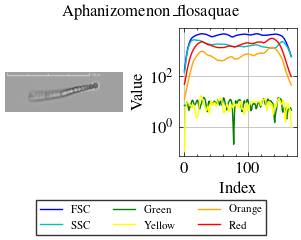

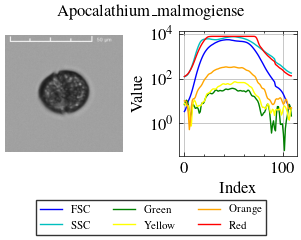

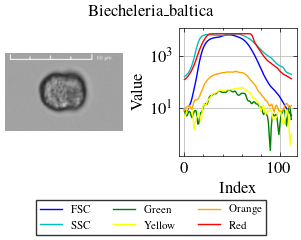

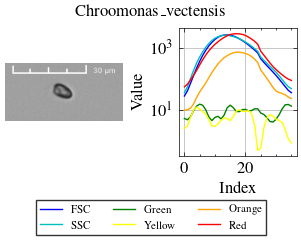

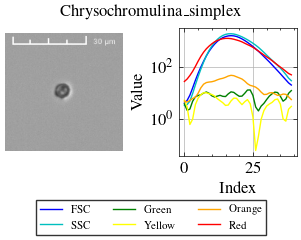

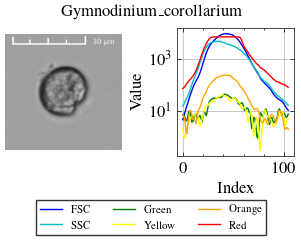

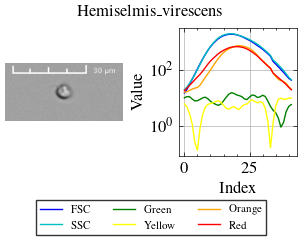

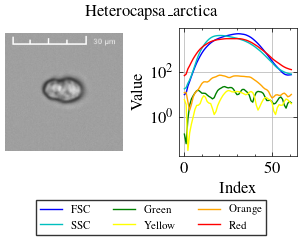

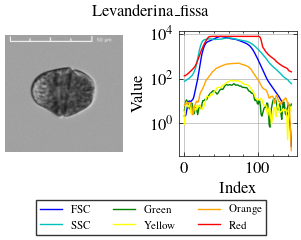

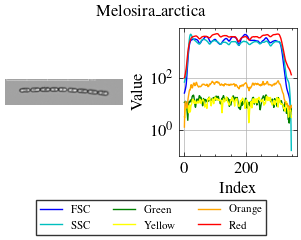

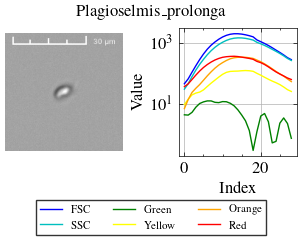

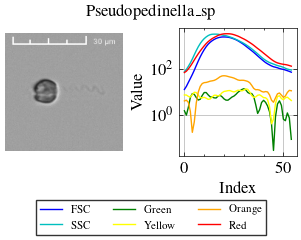

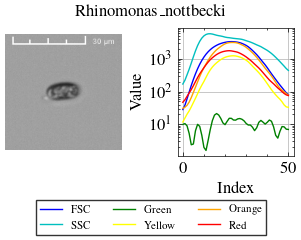

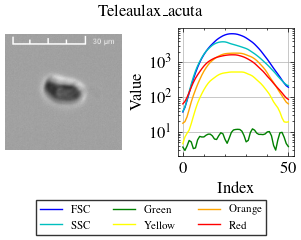

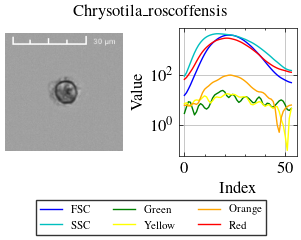

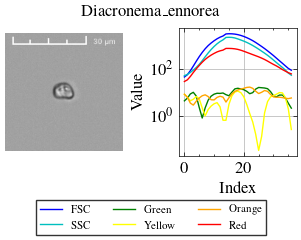

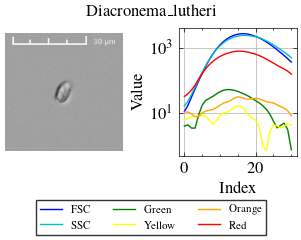

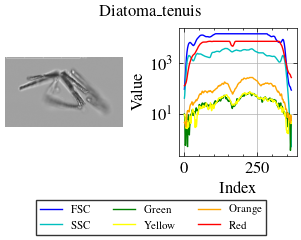

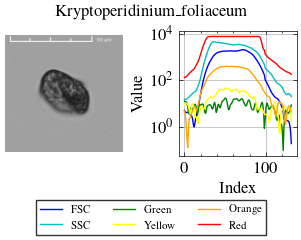

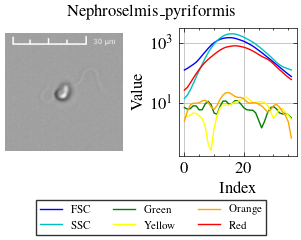

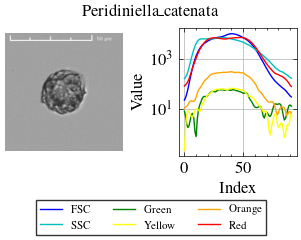

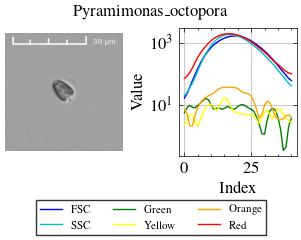

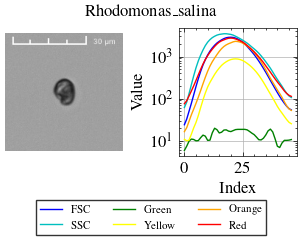

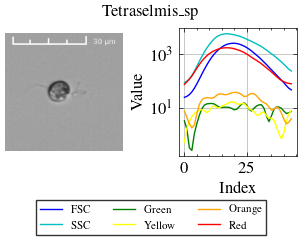

In [53]:
def visualize(sample):
    image = np.array(Image.open(image_dir / f"{sample.ID}.jpg"))
    profile = pd.read_csv(profile_dir / f"{sample.ID}.csv")

    styles = ['b', 'c', 'g', 'yellow', 'orange', 'r', 'k']

    fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")

    ax1.imshow(image)
    ax1.set_axis_off()

    ax2 = profile.plot(ax=ax2, style=dict(zip(profile.columns, styles)), legend=None)
    fig.legend(loc=8, ncols=3, frameon=True, edgecolor='k', fancybox=False, fontsize=8, bbox_to_anchor=(.5, -.2))
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Value')
    ax2.set_yscale('log')
    # ax2.set_ylim([profile.min().min(), None])

    fig.set_size_inches(3, 2)
    
    plt.grid()
    plt.suptitle(f'{sample.class_name}', fontsize=12)
    plt.savefig(f'figures/small_{sample.class_name}.pdf')
    plt.show()

for name in annotations.class_name.unique():
    for _, sample in annotations[annotations.class_name == name].sample(1).iterrows():
        visualize(sample)



In [9]:
profile = pd.read_csv(profile_dir / f"{sample.X}.csv")
profile.min().min()

NameError: name 'sample' is not defined

In [11]:
multimodal = annotations[(annotations.iloc[:, -2:] == True).all(axis=1)]
class_names, counts = np.unique(multimodal.class_name, return_counts=True)

idx = counts.argsort()[::-1]
class_names = class_names[idx]
counts = counts[idx]
print(counts)

train = pd.DataFrame(columns=multimodal.columns)
test = pd.DataFrame(columns=multimodal.columns)
valid = pd.DataFrame(columns=multimodal.columns)

size=15
for i in range(size):
    annot = multimodal[multimodal.class_name == class_names[i]]
    train_annot, test_annot = train_test_split(annot, train_size=50)
    valid_annot = test_annot.sample(10)
    train = pd.concat([train, train_annot])
    test = pd.concat([test, test_annot])
    valid = pd.concat([valid, valid_annot])

train.to_csv(data_dir / f'train_{size}.csv')
test.to_csv(data_dir / f'test_{size}.csv')
valid.to_csv(data_dir / f'valid_{size}.csv')

[1659 1016  834  792  329  253  219  203  156  146  122  116  101   91
   78   66   53   49   47   43   41   32   28   19   18   17   16   14
   13   11   10    8    3    3    3    1]


In [12]:
table = pd.read_csv('./data/CytoSense/Pulse-shapes_annotated_CS_images.csv')

In [13]:
table = table.iloc[:, -7:].dropna()
max_vals = table.max(0).to_numpy().astype(int)
min_vals = table.min(0).to_numpy().astype(int)

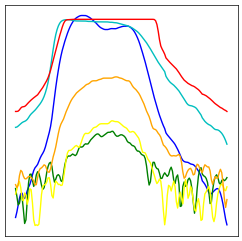

In [ ]:
    
for _, sample in annotations[annotations.iloc[:, -2:].T.all()].sample().iterrows():
    x = sample.ID

    image = Image.open(image_dir / f"{x}.jpg")
    profile = pd.read_csv(profile_dir / f"{x}.csv")
    profile = np.log(profile + 1)

    h, w = image.size

    if h == w:
        styles = ['b', 'c', 'g', 'yellow', 'orange', 'r']

        fig, ax = plt.subplots(figsize=(3, 3))
        ax = profile.plot(ax=ax, style=dict(zip(profile.columns, styles)))

        ax.legend().set_visible(False)
    
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        plt.savefig(f'figures/{x}_profile.jpg')
        image = image.resize((256, 256))
        image.save(f'figures/{x}_image.jpg')

        plt.show()


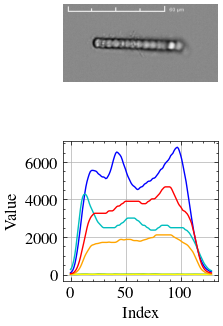

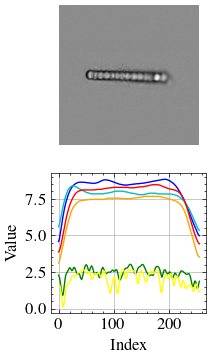

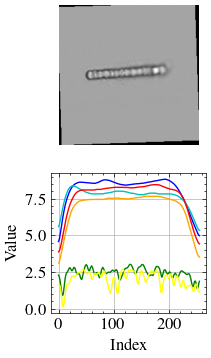

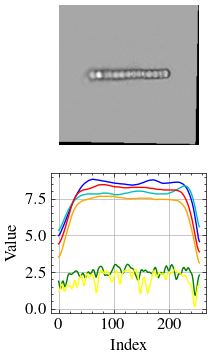

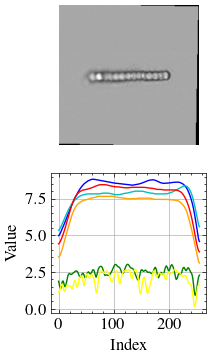

In [3]:
from src import data
import cv2
import torch

sample = annotations.iloc[243]

image = cv2.imread(image_dir / f'{sample.ID}.jpg', cv2.IMREAD_GRAYSCALE)
profile = np.loadtxt(profile_dir / f'{sample.ID}.csv', delimiter=',', skiprows=1)  
profile = torch.tensor(profile)

img_tr = data.ImageTransforms()
prf_tr = data.ProfileTransform(max_len=256)
pair_tr = data.PairAugmentation()

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(2, 4))
ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
for feature, color in zip(profile.T, ['b', 'c', 'g', 'yellow', 'orange', 'r']):
    ax2.plot(feature, color=color)
ax2.set_xlabel('Index')
ax2.set_ylabel('Value')
plt.grid()
plt.savefig(f'figures/augment_{sample.ID}_orig.pdf')

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(2, 4))
ax1.imshow(img_tr(image)[0], cmap='gray')
ax1.set_axis_off()
for feature, color in zip(prf_tr(profile).T, ['b', 'c', 'g', 'yellow', 'orange', 'r']):
    ax2.plot(feature, color=color)
ax2.set_xlabel('Index')
ax2.set_ylabel('Value')
plt.grid()
plt.savefig(f'figures/augment_{sample.ID}_proc.pdf')

for i in range(3):
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(2, 4))
    foo, bar = pair_tr(img_tr(image), prf_tr(profile))
    ax1.imshow(foo[0], cmap='gray')
    ax1.set_axis_off()
    for feature, color in zip(bar.T, ['b', 'c', 'g', 'yellow', 'orange', 'r']):
        ax2.plot(feature, color=color)
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Value')
    plt.grid()
    plt.savefig(f'figures/augment_{sample.ID}_{i}.pdf')


<>:8: SyntaxWarning: invalid escape sequence '\P'
<>:8: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_33741/3386004030.py:8: SyntaxWarning: invalid escape sequence '\P'
  ax.plot(x, gelu(x), label='GELU$(x) = x\Phi(x)$')


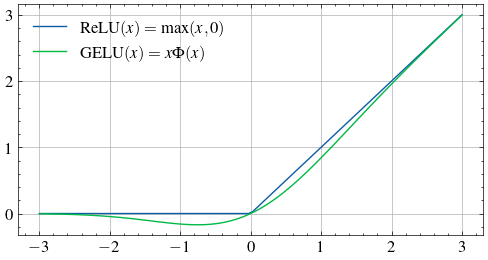

In [11]:
import torch
from torch.nn.functional import relu, gelu

fig, ax = plt.subplots(figsize=(6, 3))

x = torch.linspace(-3, 3, 100)
ax.plot(x, relu(x), label='ReLU$(x) =$ max$(x, 0)$')
ax.plot(x, gelu(x), label='GELU$(x) = x\Phi(x)$')

ax.legend()
ax.grid()
fig.savefig('figures/relugelu.pdf')

In [3]:
images = [Image.open(image_dir / f'{id}.jpg').convert('L') for id in tqdm(annotations.ID)]
profiles = [pd.read_csv(profile_dir / f'{id}.csv') for id in tqdm(annotations.ID)]



100%|██████████| 20050/20050 [00:10<00:00, 1894.50it/s]


In [4]:
size = np.array([image.size for image in images])
lengths = np.array([len(profile) for profile in profiles])


In [1]:

profiles[0].min()

NameError: name 'profiles' is not defined

In [ ]:
data_dir = Path('./data/CytoSense/')

# table = pl.scan_csv(data_dir / 'PDexp_Micro_phyto_pulse-shapes.txt', separator=' ') \
    # .select(["ID", "FWS", "SWS", "FL.Green", "FL.Yellow", 
            #  "FL.Orange", "FL.Red", "file", "Sample", "cluster"]) \
    # .filter(pl.col('ID') != 0)

schema = pl.Schema(
    {
        "ID": pl.Int64
        "FWS": pl.Float64U()
        "SWS": pl.Float64()
    }
)

table = pl.scan_csv(data_dir / 'Uto_2020_pulse-shapes.txt', 
                    separator=' ', schema=schema) \
    .select(["ID", "FWS", "SWS", "FL.Green", "FL.Yellow", 
             "FL.Orange", "FL.Red", "file", "Sample", "cluster"]) \
    .filter(pl.col('ID') != 0)

In [18]:
table.collect()

ColumnNotFoundError: ID

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
Csv SCAN [data/CytoSense/Uto_2020_pulse-shapes.txt] [id: 128291592042912]
PROJECT */1 COLUMNS

In [16]:
ids = table.ID
list(table.groupby('ID'))

: 

In [ ]:
table.ID !=

1             192
2             192
3             192
4             192
5             192
            ...  
38854511    10839
38854512    10839
38854513    10839
38854514        0
38854515        0
Name: ID, Length: 38854515, dtype: int64

In [9]:
dirs = filter(Path.is_dir, data_dir.iterdir())
files = []
for directory in dirs: 
    files.extend(directory.glob('*.jpg'))

len(files)
files

[PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-15 12h16_Cropped_With_Scalebar_985.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-14 00h16_Cropped_With_Scalebar_465.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-14 15h16_Cropped_With_Scalebar_1055.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-14 03h16_Cropped_With_Scalebar_768.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-09 02h10_Cropped_With_Scalebar_1584.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-14 12h16_Cropped_With_Scalebar_150.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-15 03h16_Cropped_With_Scalebar_130.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-14 13h16_Cropped_With_Scalebar_613.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-13 09h16_Cropped_With_Scalebar_6